In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

!pip install datasets
from datasets import load_dataset

dataset = load_dataset("liar")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

In [2]:
train_df = pd.DataFrame(dataset["train"])
train_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)
test_df =  pd.DataFrame(dataset["test"])
test_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)
valid_df =  pd.DataFrame(dataset["validation"])
valid_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)
print(dataset)
print(train_df.head())
print(test_df.head())
print(valid_df.head())

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})
           0   1                                                  2   \
0   2635.json   0  Says the Annies List political grou

In [3]:
def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x==2 or x==3 else 0 for x in dataset[1]]
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column

  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [4]:
train_df = data_preprocessing(train_df)
valid_df = data_preprocessing(valid_df)
test_df = data_preprocessing(test_df)

In [5]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
train_df['sentence']=train_df['sentence'].apply(lambda x:review_cleaning(x))
test_df['sentence']=test_df['sentence'].apply(lambda x:review_cleaning(x))
valid_df['sentence']=valid_df['sentence'].apply(lambda x:review_cleaning(x))

In [7]:
import nltk
nltk.download('stopwords')

stop = stopwords.words('english')
train_df['sentence'] = train_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_df['sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
valid_df['sentence'] = valid_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting none news release healt...
4,0,economyjobs charliecrist florida democrat inte...


In [8]:
max_words = 5000
maxlen = 100
tokenizer0 = Tokenizer(num_words=max_words)
tokenizer0.fit_on_texts(train_df['sentence'])

tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(test_df['sentence'])

tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(valid_df['sentence'])

train_sequences = tokenizer0.texts_to_sequences(train_df['sentence'])
test_sequences = tokenizer1.texts_to_sequences(test_df['sentence'])
valid_sequences = tokenizer2.texts_to_sequences(valid_df['sentence'])

x_train = pad_sequences(train_sequences, maxlen=maxlen)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
x_valid = pad_sequences(valid_sequences, maxlen=maxlen)

y_train = train_df['label']
y_train = pd.get_dummies(y_train)

y_test = test_df['label']
y_test = pd.get_dummies(y_test)

y_valid = valid_df['label']
y_valid = pd.get_dummies(y_valid)

In [22]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Activation

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
num_epochs = [5]
dropout_rates = [0.1, 0.2, 0.3]

best_accuracy = 0
best_hyperparameters = {}
i = 0
for lr in learning_rates:
    for bs in batch_sizes:
        for ne in num_epochs:
            for dr in dropout_rates:
                print(i)
                # Create and compile the model
                model = Sequential()
                model.add(Embedding(max_words, 64, input_length=maxlen))
                model.add(Conv1D(32, 5, activation='relu'))
                model.add(GlobalMaxPooling1D())
                model.add(Flatten())
                model.add(Dense(64, activation='relu'))
                model.add(Dropout(dr))
                model.add(Dense(2, activation='sigmoid'))

                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                # Train the model
                history = model.fit(x_train, y_train, epochs=ne, batch_size=bs, validation_data=(x_valid, y_valid), verbose=0)

                # Evaluate the model
                loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
                i += 1

                # Update best hyperparameters if accuracy improves
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparameters = {'learning_rate': lr, 'batch_size': bs, 'num_epochs': ne, 'dropout_rate': dr}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Test Accuracy:", best_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Best Hyperparameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 5, 'dropout_rate': 0.1}
Best Test Accuracy: 0.6414653062820435


Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, 100, 64)           320000    
                                                                 
 conv1d_70 (Conv1D)          (None, 96, 32)            10272     
                                                                 
 global_max_pooling1d_70 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 flatten_70 (Flatten)        (None, 32)                0         
                                                                 
 dense_140 (Dense)           (None, 64)                2112      
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='Predicted', ylabel='Actual'>

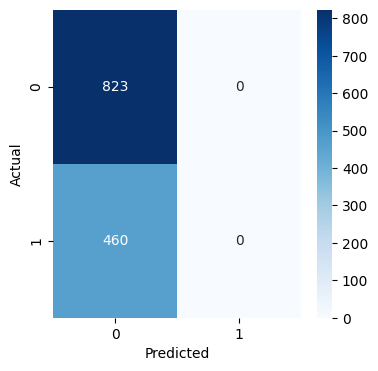

In [24]:
# model = Sequential()
# model.add(Embedding(max_words, 64, input_length=maxlen))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(2, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model = Sequential()
model.add(Embedding(max_words, 64, input_length=maxlen))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(x_train, y_train, epochs=ne, batch_size=bs, validation_data=(x_valid, y_valid), verbose=0)

y_pred0 = model.predict(x_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')